In [1415]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pylab import rcParams
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
import warnings; warnings.simplefilter('ignore')

rcParams['figure.figsize'] = 18, 8

%matplotlib inline

Questions:
1. Using January to November as a training set, we wish to step through every day in
December, and using all data prior to that date, forecast the total number of entries on
that day. Ensure that you do whatever data cleaning and filtering is necessary. What is
the most appropriate metric for evaluating success?
2. Similar to 1, forecast turnstile entries for every station individually for every day in
December. Is this problem easier or harder than forecasting for the system as a whole?
3. Augment your solution to 2. With whatever external data (one or two sources) you think
is most appropriate. Explain why you think this data would be useful in predicting
ridership and the improvement in predictive accuracy.

# 1. Daily Total Forecast for December

Notes 
- Download data
- Clean data
    - Remove unneeded columns
    - Make sure all columns are same type and correct type ('Date' is date, etc.)
- Aggregate entries daily by station and for NYC overall
    - Looks like stations are not unique on 'Station'. For example, the station name 'FULTON ST' refers to either the Fulton Street station on the G train in Brooklyn and the ACJZ2345 trains in Manhattan. Furthermore, for this Manhattan Fulton Street station, it looks like the 'Line Name' column can either be 'ACJZ2345' or '2345ACJZ'.
    - It's not quite an exact unique identifier, but I will use 'Unit' as the station identifier because it seems close enough
    - The 'Entries' columns is cumulative. My plan is to keep the max observation for each device each day, sum all devices across the station, and take the difference from the previous day.
    - Deal with unusual looking data points (ie. several days missing in the record, or the device "rolls over" to 0, or there's a device malfunction) by removing outliers
- Reserve December data for testing
- Plot daily entry data
- Try AR, MA and ARIMA model and assess

In [1412]:
data = pd.read_csv('https://data.ny.gov/api/views/ekwu-khcy/rows.csv?accessType=DOWNLOAD')

/Users/michelleho/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [1033]:
# Run this cell if you already have the data downloaded and stored
# data = pd.read_csv('Turnstile_Usage_Data__2016.csv')

/Users/michelleho/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning

In [1290]:
# Investigating what the station identifier might be..
data.groupby(['Unit','Station', 'Line Name']).size().reset_index().rename(columns={0:'count'}).head(20)

,Unit,Station,Line Name,count
0,R001,SOUTH FERRY,1R,25421
1,R001,SOUTH FERRY,1RW,5039
2,R001,WHITEHALL S-FRY,1R,26311
3,R001,WHITEHALL S-FRY,1RW,5085
4,R003,CYPRESS HILLS,J,6189
5,R004,75 ST-ELDERTS,JZ,10366
6,R005,85 ST-FOREST PK,J,8176
7,R006,WOODHAVEN BLVD,JZ,16394
8,R007,104 ST,JZ,8210
9,R008,111 ST,J,8309


From this quick investigation, I see it will be difficult trying to separate out individual stations (just look at 42 ST-PORT AUTH for example). However, I think using the 'Unit' as the station identifier is "good enough" for the purposes of this exercise, since there are 467 distinct Unit values and that is almost how many MTA stations there are.

In [1292]:
print('Unique UNIT values:',len(data['Unit'].unique()))

Unique UNIT values: 467


In [1418]:
data.shape

(9492670, 11)

In [1419]:
# Problematic Fulton Street example
data[data['Station'] == 'FULTON ST']['Line Name'].unique()

array(['ACJZ2345', '2345ACJZ', 'G'], dtype=object)

In [1420]:
# Drop non-regular readings
print('Non-regular readings dropped:', data.shape[0] - data[data['Description'] == 'REGULAR'].shape[0])
data = data[data['Description'] == 'REGULAR']

Non-regular readings dropped: 41061


In [1421]:
# Fixing date times
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)

In [1422]:
# Take the maximum value seen each day for each device (SCP)
max_data = data[['Date','SCP','Unit','Entries']].groupby(['Date','Unit','SCP']).max()

In [1423]:
max_data.reset_index(inplace=True)

In [1424]:
# Try with a sample first of one station 'R004' the 75 ST-ELDERTS station in Queens
max_data_sample = max_data[max_data['Unit'] == 'R004']
cumulative_daily_station_sample = max_data_sample[['Date','Unit','Entries']].groupby(['Unit','Date']).sum()
shifted_sample = cumulative_daily_station_sample['Entries'].groupby(level=0).shift()
# cumulative_daily_station_sample['Entries'].sub(shifted_sample).head(30)

# The sudden decrease in entries for 1/23/2016 is due to blizzard!
# https://en.wikipedia.org/wiki/January_2016_United_States_blizzard

In [1425]:
# All stations now
cumulative_daily_station = max_data[['Date','Unit','Entries']].groupby(['Unit','Date']).sum()
shifted = cumulative_daily_station['Entries'].groupby(level=0).shift()
daily_station = cumulative_daily_station['Entries'].sub(shifted)
# daily_station.tail(15)

In [1426]:
# Drop negative values (these don't make sense, perhaps the device rolled over or malfunctioned)
nonnegative_daily_station = daily_station[daily_station > 0]
# Number of negative observations lost
print('Number of negative observations lost:', daily_station.shape[0] - nonnegative_daily_station.shape[0])

Number of negative observations lost: 1970


In [1427]:
# Take average of entries over days from last observation to deal with missing days
nonnegative_daily_station = nonnegative_daily_station.reset_index(level=1)
dates = nonnegative_daily_station.Date
day_delta = dates - dates.groupby(level=0).shift()
day_delta = day_delta.apply(lambda x: x.days)
nonnegative_daily_station['Day Delta'] = day_delta
nonnegative_daily_station['Averaged Entries'] = nonnegative_daily_station.Entries/day_delta

In [1428]:
nonnegative_daily_station['Averaged Entries'].fillna(nonnegative_daily_station.Entries, inplace=True)

In [1429]:
# Remove rows that are outliers 
zscore_function = lambda x: (x - x.mean()) / x.std()
zscores = nonnegative_daily_station['Averaged Entries'].groupby('Unit').transform(zscore_function)
nonnegative_daily_station['Zscore'] = zscores
# Filter out values beyond 3 standard deviation of mean for that station
clean_daily_station = nonnegative_daily_station[abs(zscores.values) < 3]

In [1430]:
nonnegative_daily_station.reset_index()[nonnegative_daily_station.reset_index()['Unit'] == 'R051'].describe()

,Entries,Day Delta,Averaged Entries,Zscore
count,333.000,332.000,333.000,333.000
mean,2143667.586,1.090,2140857.781,0.000
std,37844132.013,0.941,37844276.211,1.000
min,7299.000,1.000,7299.000,-0.056
25%,25761.000,1.000,25615.000,-0.056
50%,37179.000,1.000,37022.000,-0.056
75%,39569.000,1.000,39500.000,-0.056
max,690614127.000,15.000,690614127.000,18.192


In [1431]:
print("Outliers removed:", zscores.shape[0] - clean_daily_station.shape[0])

Outliers removed: 854


In [1432]:
clean_daily_station.rename(columns={"Averaged Entries": "Total Entries"}, inplace=True)

In [1433]:
# Sum all stations daily for NYC Total (for Part 1 of this assignment)
nyc_daily_entries = clean_daily_station.groupby('Date').sum()
nyc_daily_entries.describe()

,Entries,Day Delta,Total Entries,Zscore
count,335.000,335.000,335.000,335.000
mean,17989303.899,499.313,10506698.758,-8.301
std,120586883.242,421.048,22677727.711,256.187
min,1047692.000,0.000,1043990.500,-592.267
25%,4121581.000,458.000,3884955.500,-287.492
50%,5728789.000,461.000,5683944.500,118.576
75%,6127030.000,466.000,6086340.591,198.417
max,2168507525.000,6745.000,239993785.000,256.462


Text(0.5,1,'Total Entries, with outliers')

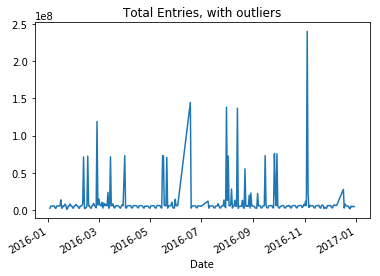

In [1434]:
# There seems to be some crazy outliers still... And they appear where the record is missing days.
# But I can see an underlying weekly pattern
nyc_daily_entries['Total Entries'].plot()
plt.title('Total Entries, with outliers')

In [1435]:
# Drop outliers for nyc_daily_entries, within an std of 1
nyc_zscores = nyc_daily_entries['Total Entries'].transform(zscore_function)
clean_nyc_daily = nyc_daily_entries[abs(nyc_zscores.values) < 1]
print('Outlier days dropped:', nyc_daily_entries.shape[0] - clean_nyc_daily.shape[0])

Outlier days dropped: 18


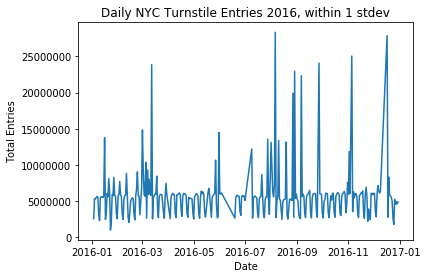

In [1436]:
# There are still days that in which turnstile entries jump, but let's leave them for now.
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.ticklabel_format(style='plain')
plt.ylabel('Total Entries')
plt.xlabel('Date')
plt.title('Daily NYC Turnstile Entries 2016, within 1 stdev')
plt.plot(clean_nyc_daily['Total Entries'])
plt.show()

In [1437]:
df = clean_daily_station.reset_index()
df_pivot = df.pivot(index='Date',columns='Unit', values='Total Entries')

In [1438]:
df_pivot.shape

(335, 467)

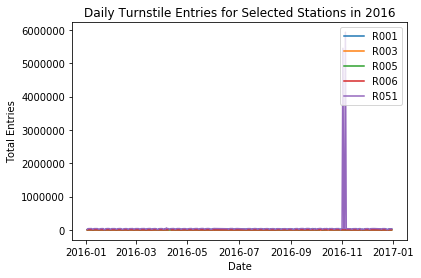

In [1439]:
# Plot select stations. Big outlier for Station R051...
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.ticklabel_format(style='plain')
plt.ylabel('Total Entries')
plt.xlabel('Date')
plt.title('Daily Turnstile Entries for Selected Stations in 2016')
for column in ['R001','R003','R005','R006','R051']:
    plt.plot(df_pivot[column], label=column)
plt.legend(loc=1)
plt.show()

In [1440]:
# Remove outliers beyond 99th percentile.
# It looks like for stations like 'R051' the standard deviation is huge
count = 0
for col in df_pivot.columns:
    q1 = df_pivot[col].quantile(0)
    q99 = df_pivot[col].quantile(.99)
    mask = df_pivot[col].between(q1, q99, inclusive=True)
    count += mask.value_counts()[False]
    df_pivot[col] = df_pivot.loc[mask, col]
print('Outliers removed:', count)

Outliers removed: 5407


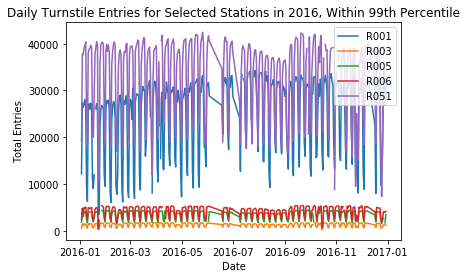

In [1441]:
# Plot each stations. Much better now!
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.ticklabel_format(style='plain')
plt.ylabel('Total Entries')
plt.xlabel('Date')
plt.title('Daily Turnstile Entries for Selected Stations in 2016, Within 99th Percentile')
for column in ['R001','R003','R005','R006','R051']:
    plt.plot(df_pivot[column], label=column)
plt.legend(loc=1)
plt.show()

In [1442]:
# Sum across stations for NYC total now
df_pivot.reset_index(inplace=True)
df_stations = df_pivot.drop('Date', axis=1)
df_pivot['NYC_Total'] = df_stations.sum(axis=1)

In [1443]:
df_pivot.shape

(335, 469)

In [1444]:
# fill missing values with the previous value (forward fill)
df_pivot.set_index('Date',inplace=True)
df_pivot = df_pivot.asfreq('D')
df_pivot.fillna(method='ffill', inplace=True)

In [1445]:
# Grab test dataset and training set
december = df_pivot.loc['2016-12-01':]
training = df_pivot.loc[:'2016-11-30']

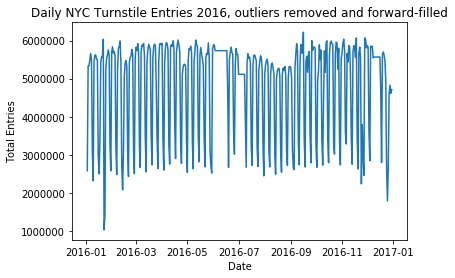

In [1446]:
# Much better looking!
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.ticklabel_format(style='plain')
plt.ylabel('Total Entries')
plt.xlabel('Date')
plt.title('Daily NYC Turnstile Entries 2016, outliers removed and forward-filled')
plt.plot(df_pivot['NYC_Total'])
plt.show()

## Timeseries Modeling

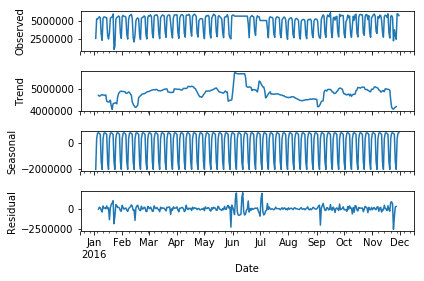

In [1447]:
decomposition = sm.tsa.seasonal_decompose(training['NYC_Total'], freq=7, model='additive')
fig = decomposition.plot()
plt.show()

On visual inspection, we can see a clear weekly "seasonality" of turnstile entries, with more entries during the work week and fewer entries on the weekend. As for the overall trend, I notice a slight decline in entries during the summer. This may be because of students leaving NYC and people taking vacations during these months. This suggests the data may not be stationary.

Text(0.5,1,'Rolling Mean & Standard Deviation')

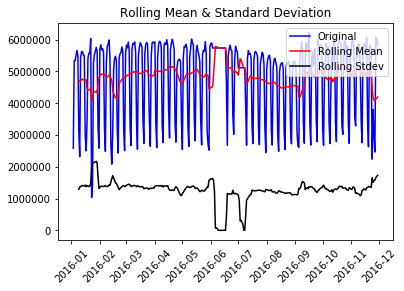

In [1448]:
# Check for stationarity
rolling_mean = training['NYC_Total'].rolling(window=7).mean()
rolling_stdev = training['NYC_Total'].rolling(window=7).std()

# Plot rolling stats
orig = plt.plot(training['NYC_Total'], color='blue',label='Original')
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
std = plt.plot(rolling_stdev, color='black', label = 'Rolling Stdev')
plt.legend(loc=1)
plt.xticks(rotation=45)

plt.title('Rolling Mean & Standard Deviation')

In [1449]:
print('Dickey-Fuller Test')
dftest = adfuller(training['NYC_Total'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test
Test Statistic                 -3.244
p-value                         0.018
#Lags Used                     14.000
Number of Observations Used   318.000
Critical Value (1%)            -3.451
Critical Value (5%)            -2.871
Critical Value (10%)           -2.572
dtype: float64


The test statistic is smaller than the 5% critical value, so with 95% confidence this is a stationary series for our purposes.


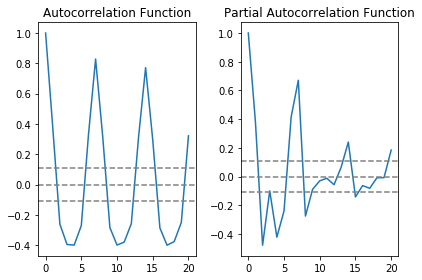

In [1450]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(training['NYC_Total'], nlags=20)
lag_pacf = pacf(training['NYC_Total'], nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(training['NYC_Total'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(training['NYC_Total'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(training['NYC_Total'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(training['NYC_Total'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# AR Model


I chose a lag of 7 days for both P and Q parameters because of the weekly pattern.

Text(0.5,1,'RMSE: 625784.4621')

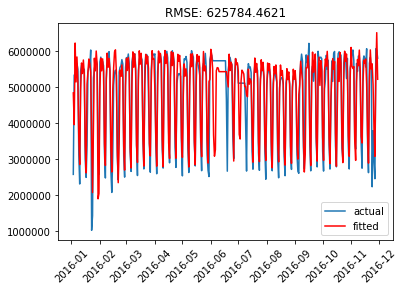

In [1451]:
# autocorrelation lag of 7 days, difference 0
model = ARIMA(training['NYC_Total'], order=(7, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(training['NYC_Total'], label="actual")
plt.plot(results_AR.fittedvalues, color='red', label="fitted")
plt.legend()
plt.xticks(rotation=45)
plt.title('RMSE: %.4f'% np.sqrt(sum((results_AR.fittedvalues-training['NYC_Total'])**2)/len(training['NYC_Total'])))

# MA Model

Text(0.5,1,'RMSE: 807808.5515')

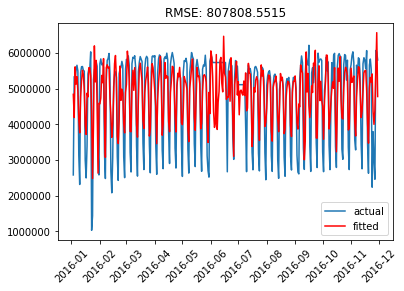

In [1452]:
model = ARIMA(training['NYC_Total'], order=(0, 0, 7))  
results_MA = model.fit(disp=-1)  
plt.plot(training['NYC_Total'], label="actual")
plt.plot(results_MA.fittedvalues, color='red', label='fitted')
plt.legend()
plt.xticks(rotation=45)
plt.title('RMSE: %.4f'% np.sqrt(sum((results_MA.fittedvalues-training['NYC_Total'])**2)/len(training['NYC_Total'])))

# ARIMA Model

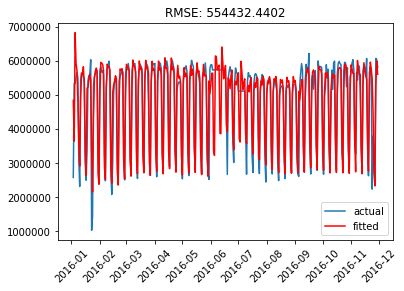

In [1453]:
model = ARIMA(training['NYC_Total'], order=(7, 0, 7))  
results_ARIMA = model.fit(disp=-1)  
ax = plt.plot(training['NYC_Total'], label="actual")
plt.plot(results_ARIMA.fittedvalues, color='red', label='fitted')
plt.legend()
plt.xticks(rotation=45)
plt.title('RMSE: %.4f'% np.sqrt(sum((results_ARIMA.fittedvalues-training['NYC_Total'])**2)/len(training['NYC_Total'])))
plt.show()

The root mean squared error (variance of the residual) is lower for the ARIMA model compared to the AR and MA model.

# Forecast for December

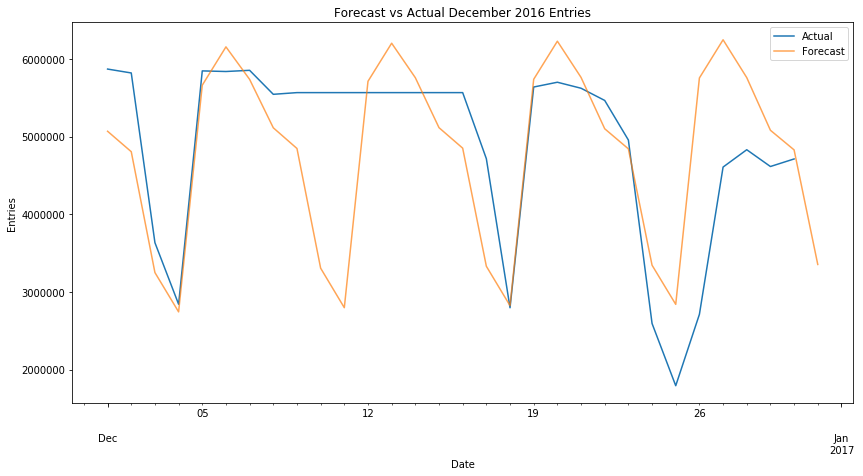

In [1454]:
pred = results_ARIMA.predict(start='2016-12-01', end='2016-12-31', dynamic=False)
ax = df_pivot.loc['2016-12-01':]['NYC_Total'].plot(label='Actual')
pred.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Entries')
plt.title('Forecast vs Actual December 2016 Entries')
plt.legend()
plt.show()

There are 8 days missing in December from the observed data points, so in a sense we "recovered" a weekly trend in our forecast that isn't found in the observed data. Furthermore, there's no way for this model to be able to predict the Christmas holiday drop in ridership with the previous 11 months of data. Given these issues, I would argue this model isn't doing too bad. If we look at the root mean squared error (RMSE) of this forecast, it will be unfairly high because of the missing 8 days.

In [1455]:
actual = df_pivot.loc['2016-12-01':]['NYC_Total']

In [1456]:
print('Average daily entries:',df_pivot['NYC_Total'].mean())

Average daily entries: 4845494.369354848


In [1457]:
rmse = np.sqrt(((pred - actual) ** 2).mean())
print("RMSE for December Forecast: ", rmse)

RMSE for December Forecast:  1059991.6685934917


A RMSE of approximately 1,059,992 means that we are off by slightly more than 1 million entries each day for December. Given that the average daily entry is 4.8 million, this is a large error. But once again, this RMSE is unfairly high because of the missing data. Finally, our ARIMA model in-sample RMSE was approximately 0.5 million, which is not too bad.

# 2. Individual station forecast

Rather than fit an ARIMA model to each station, I'm going to attempt a single model to predict each station (as done by: http://mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/). Mario uses a random forest regressor on the concatenated "melted" form of the dataframe. This will require feature engineering to create the lags manually.

In [1458]:
df_melt = pd.melt(df_pivot.reset_index(), id_vars=['Date'])

In [1459]:
df_station = df_melt[df_melt['Unit'] != 'NYC_Total']

In [1460]:
station_ids = df['Unit'].unique()

## Feature Engineering:
- Create a lag variable of the value for that station 7 days ago
- Difference the previous two weeks
- Rolling mean of previous seven days

In [1461]:
df_station2 = df_station.copy()
df_station2['last_week_entries'] = df_station2.groupby(['Unit'])['value'].shift(7)
rolling_means_df = df_station2.groupby('Unit').value.rolling(7).mean()
rolling_means = rolling_means_df.reset_index()['value']
df_station2['rolling_mean_prevweek'] = rolling_means
df_station2['last_two_weeks_diff'] = df_station2.groupby(['Unit'])['last_week_entries'].diff(7)
df_station2 = df_station2.dropna()

In [1462]:
df_station2.head()

,Date,Unit,value,last_week_entries,rolling_mean_prevweek,last_two_weeks_diff
14,2016-01-17,R001,9025.000,6281.000,21937.143,-5863.000
15,2016-01-18,R001,11955.000,26461.000,19864.857,-896.000
16,2016-01-19,R001,11955.000,27161.000,17692.571,751.000
17,2016-01-20,R001,26067.000,25942.000,17710.429,-1119.000
18,2016-01-21,R001,27189.000,27273.000,17698.429,-783.000


We've been using the RMSE so far, so let's continue using that to evaluate.

In [1463]:
def rmse(ytrue, ypred):
    return np.sqrt(((ypred - ytrue) ** 2).mean())

For a baseline model, let's simply predict the previous week's values, and see how our model performs across all stations.

In [1464]:
dates = df_station2.Date.unique()

In [1465]:
december_dates = df_station2[df_station2.Date >= pd.to_datetime('2016-12-01')].Date.unique()

In [1466]:
errors = []
for date in dates:
    val = df_station2[df_station2['Date'] == date]
    history = df_station2[df_station2['Date'] < date]
    pred = val['last_week_entries'].values
    error = rmse(val['value'].values, pred)
#     print('Day {} - Error {:.2f}'.format(str(date)[:10], error))
    errors.append(error)
print('Mean Error (Whole Dataset) = {:.5f}'.format(np.mean(errors)))

# errors = []
# for date in december_dates:
#     val = df_station2[df_station2['Date'] == date]
#     history = df_station2[df_station2['Date'] < date]
#     pred = val['last_week_entries'].values
#     error = rmse(val['value'].values, pred)
#     print('Day {} - Error {:.2f}'.format(str(date)[:10], error))
#     errors.append(error)
# print('Baseline model mean error for December = %.5f' % np.mean(errors))

Mean Error (Whole Dataset) = 5178.38101


This mean error tells us that if we merely predict the previous week's value for our new day for each station, we will have an average error of 5178 entries for the average station. With 467 stations, that means our total NYC error would be approximately 2 million, which is higher than the error of our total NYC model before. We will be hoping to beat this metric with our model that takes into account our engineered features. Let's attempt to fit a random forest to our data.

Decision trees allow for categorical values, but not before one-hot encoding in the sci-kit library (Mario makes a mistake in not doing this in his example). To deal with this, I will create dummy variables for the station.

In [ ]:
dummied_data = pd.get_dummies(df_station2)
dummied_data2 = dummied_data.copy()

In [ ]:
ordinal_days = (dummied_data.Date - pd.to_datetime('2016-01-01')).apply(lambda x: x.days)

In [ ]:
dummied_data['Date'] = ordinal_days

In [1398]:
errors = []
history = dummied_data[dummied_data['Date'] < 335]
xtr, ytr = history.drop(['value'], axis=1), history['value'].values
mdl = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=0)

In [1388]:
# Only fit model using training data up to Dec 1
mdl.fit(xtr, ytr)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [1389]:
for december_date in range(335,365):
    val = dummied_data[dummied_data['Date'] == december_date]

    xts, yts = val.drop(['value'], axis=1), val['value'].values
    
    # Ideally, in stepping through December dates, we add our predictions to the training dataframe
    # and create our engineered features from those (since we shouldn't have knowledge of the future!)
    # but for now let's use the existing test variables to keep things simple.
    
    pred = mdl.predict(xts)
    error = rmse(yts, pred)
    print('Day {} - Error {:.2f}'.format(str(december_date), error))
    errors.append(error)
    
print('Mean Error = %.5f' % np.mean(errors))

Day 335 - Error 17811.51
Day 336 - Error 18109.94
Day 337 - Error 18857.48
Day 338 - Error 19073.69
Day 339 - Error 7469.88
Day 340 - Error 4756.15
Day 341 - Error 4291.86
Day 342 - Error 5034.16
Day 343 - Error 14469.28
Day 344 - Error 14877.75
Day 345 - Error 14871.36
Day 346 - Error 13881.94
Day 347 - Error 12100.85
Day 348 - Error 12436.70
Day 349 - Error 13861.89
Day 350 - Error 4889.73
Day 351 - Error 5265.50
Day 352 - Error 20487.43
Day 353 - Error 17850.92
Day 354 - Error 17561.60
Day 355 - Error 15969.00
Day 356 - Error 6945.77
Day 357 - Error 5554.92
Day 358 - Error 10530.90
Day 359 - Error 10987.66
Day 360 - Error 10189.95
Day 361 - Error 4285.01
Day 362 - Error 2767.63
Day 363 - Error 2791.48
Day 364 - Error 2452.10
Mean Error = 11014.46887


The mean error we get for running this random forest model fit on the training dataset on the test dataset is 11,014, which means we are off by approximately this many entries for each station each day in December. Although this is worse than our baseline model, it's not too bad, especially since we are still dealing with the 8 days of missing data and the Christmas holiday effect. Given more time, I would tune hyper-parameters and increase the number of estimators in the random forest model. I also think that dummying the data to handle the categorical station variable is not very effective because there are many stations and we add 467 (mostly useless) new features to the dataset. I would explore using a different model or library that can handle categorical variables better.

# 3. Augment station-specific model

I plan to augment my station-specific model by adding a column indicating major US holidays as a binary feature (from https://www.kaggle.com/gsnehaa21/federal-holidays-usa-19662020#usholidays.csv) and weather variables (from https://www.kaggle.com/mathijs/weather-data-in-new-york-city-2016). I chose these because it appears on visual inspection of the data that events like major blizzards and US holidays like Christmas can influence ridership. The weather dataset contains the following variables: 
- maximum temperature
- minimum temperature
- average temperature
- precipitation
- snow fall
- snow depth

There are several problems with choosing weather and holidays. First, both apply to NYC on the whole, which means that a station-specific model will not really benefit. Second, if the constraints of this assignment is to use only January - November data as training data to predict all of December, then we won't have the December weather beforehand to plug into our model (this would be knowledge of the future). However, I'm going to proceed with using the weather data for the purposes of this exercise, with the assumption that a separate weather forecast can be used for the test dataset.

Ideally, I would love to incorporate some location information. Unfortunately, a cursory Google search yields no easy way to connect this MTA turnstile data with a latitude/longitude because of the lack of a consistent station identifier. If I had location information, this would enable us to augment with census information, which could indicate whether a stop is located in a residential or commercial area and how many people live nearby. I believe these variables would help greatly in these predictions. Without location information, however, we're unable to augment our model with any station-specific data.

In [1273]:
weather = pd.read_csv('weather_data_nyc_centralpark_2016.csv')

In [1354]:
weather.dtypes

date                   datetime64[ns]
maximum temperature             int64
minimum temperature             int64
average temperature           float64
precipitation                  object
snow fall                      object
snow depth                     object
dtype: object

In [1319]:
weather['date'] = pd.to_datetime(weather['date'], infer_datetime_format=True)

In [1356]:
# T indicates "trace" in the weather dataset, change to 0.0001
weather.replace(to_replace='T', value=0.0001, inplace=True)

In [1357]:
holidays = pd.read_csv('usholidays.csv')
holidays['Date'] = pd.to_datetime(holidays['Date'], infer_datetime_format=True)
holidays_2016 = holidays[holidays["Date"].apply(lambda x: x.year) == 2016]

In [1358]:
holidays_2016

,Unnamed: 0,Date,Holiday
50,50,2016-01-01,New Year's Day
51,51,2016-01-18,"Birthday of Martin Luther King, Jr."
52,52,2016-02-15,Washington's Birthday
53,53,2016-05-30,Memorial Day
54,54,2016-07-04,Independence Day
55,55,2016-09-05,Labor Day
56,56,2016-10-10,Columbus Day
57,57,2016-11-11,Veterans Day
58,58,2016-11-24,Thanksgiving Day
59,59,2016-12-26,Christmas Day


In [1400]:
augment_data = dummied_data2

In [1402]:
augment_data['holiday'] = 0
augment_data['holiday'][augment_data['Date'].isin(holidays_2016.Date)] = 1

/Users/michelleho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1403]:
augment_data = augment_data.merge(weather, left_on='Date', right_on='date')

In [1404]:
augment_data.drop('date', axis=1, inplace=True)

In [1407]:
ordinal_days = (augment_data.Date - pd.to_datetime('2016-01-01')).apply(lambda x: x.days)
augment_data['Date'] = ordinal_days

In [1408]:
errors = []
training = augment_data[augment_data['Date'] < 335]
xtr, ytr = training.drop(['value'], axis=1), training['value'].values
mdl = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=0)
# Only fit model using training data up to Dec 1
mdl.fit(xtr, ytr)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [1409]:
for december_date in range(335,365):
    val = augment_data[augment_data['Date'] == december_date]

    xts, yts = val.drop(['value'], axis=1), val['value'].values
        
    pred = mdl.predict(xts)
    error = rmse(yts, pred)
    print('Day {} - Error {:.2f}'.format(str(december_date), error))
    errors.append(error)
    
print('Mean Error = %.5f' % np.mean(errors))

Day 335 - Error 18590.65
Day 336 - Error 18020.18
Day 337 - Error 18644.32
Day 338 - Error 18859.29
Day 339 - Error 2987.34
Day 340 - Error 2622.78
Day 341 - Error 2545.15
Day 342 - Error 4284.47
Day 343 - Error 15379.18
Day 344 - Error 14660.27
Day 345 - Error 14602.14
Day 346 - Error 14661.21
Day 347 - Error 11726.13
Day 348 - Error 13293.90
Day 349 - Error 12448.97
Day 350 - Error 4470.11
Day 351 - Error 3285.82
Day 352 - Error 20483.17
Day 353 - Error 17593.69
Day 354 - Error 17319.00
Day 355 - Error 11646.41
Day 356 - Error 2663.60
Day 357 - Error 3801.47
Day 358 - Error 9529.63
Day 359 - Error 11493.67
Day 360 - Error 2313.03
Day 361 - Error 3794.27
Day 362 - Error 2443.04
Day 363 - Error 2267.58
Day 364 - Error 2216.75
Mean Error = 9954.90770


With the addition of weather and holiday variables, our RMSE for this model decreased, which was expected.